In [200]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import fsolve
import astropy.constants as cst
import astropy.units as u
import pandas as pd
from scipy.optimize import root_scalar
from scipy.special import kv as Kv  
from scipy.integrate import quad, cumulative_trapezoid as cumtrapz
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid


# Constantes physiques
m_p = cst.m_p.to('g').value    # masse du proton [g]
m_e = cst.m_e.to('g').value    # masse de l'électron [g]
c = cst.c.to('cm/s').value     # vitesse de la lumière [cm/s]
sigma_T = cst.sigma_T.to('cm^2').value  # section efficace de Thomson [cm^2]
q_e = 4.80320425e-10           # charge de l'électron [esu]



class OnAxisJet:
    def __init__(self):
        # Paramètres du jet article
        self.E_iso = 1e53
        self.n_0 = 1e-3
        self.epsilon_e = 0.1
        self.epsilon_B = 1e-4
        self.p = 2.2
        self.theta_obs = 0.0

        # Grilles pour interpolation rapide
        self._t_grid = np.logspace(2, 7, 1000)
        self._gamma_grid = np.array([self.gamma_shock(t) for t in self._t_grid])
        beta_vals = np.sqrt(1 - 1 / self._gamma_grid**2)
        R_vals = cumulative_trapezoid(beta_vals * c, self._t_grid, initial=0)

        self._gamma_interp = interp1d(self._t_grid, self._gamma_grid, fill_value="extrapolate")
        self._R_interp = interp1d(self._t_grid, R_vals, fill_value="extrapolate")

    
    def gamma_interp(self, t):
        return float(self._gamma_interp(t))

    def shock_radius_interp(self, t):
        return self._R_interp(t).item()


    def gamma_shock(self, t):
        C_BM = np.sqrt(17 * self.E_iso / (8 * np.pi * self.n_0 * m_p * c**5))
        C_ST = (2/5) * 1.15 * (self.E_iso / (self.n_0 * m_p * c**5))**(1/5)
        Gamma_max = 100
        gamma2_beta2 = min((C_BM**2) * t**(-3), (C_ST**2) * t**(-6/5), Gamma_max**2)
        beta_sh = np.sqrt(gamma2_beta2 / (1 + gamma2_beta2))
        return 1 / np.sqrt(1 - beta_sh**2)

    def shock_radius(self, t):
        def beta_sh(t_prime):
            Gamma = self.gamma_shock(t_prime)
            if Gamma <= 1: return 0.0
            return np.sqrt(1 - 1 / Gamma**2)
        return c * quad(beta_sh, 0, t)[0]

    def downstream_properties(self, t):
        Gamma_sh = self.gamma_interp(t)  # rapide
        Gamma = Gamma_sh / np.sqrt(2)
        n_prime = 4 * Gamma_sh * self.n_0
        e_prime = 4 * Gamma_sh**2 * self.n_0 * m_p * c**2
        return Gamma, n_prime, e_prime

    def solve_emission_time(self, T_obs, mu):
        def equation(t):
            R = self.shock_radius_interp(t)  # rapide
            return mu * R / c + T_obs - t
        return fsolve(equation, T_obs)[0]


    def compute_zeta(self, Gamma):
        if Gamma < 1.01:
            print(f" Zeta non résolu pour Gamma = {Gamma:.3f} → Gamma trop faible ou non physique")
            raise RuntimeError("Gamma trop faible")

        def equation(zeta):
            if zeta <= 0:
                return 1e10
            h_over_mc2 = Kv(3, zeta) / Kv(2, zeta)
            return h_over_mc2 - 1 / zeta - Gamma

        try:
            sol = root_scalar(equation, bracket=[1e-3, 100], method='brentq')
            if sol.converged:
                return sol.root
        except:
            print(f" Zeta non résolu pour Gamma = {Gamma:.3f} → Aucun changement de signe")
            raise RuntimeError("Pas de solution")



    def gamma_hat(self, zeta):
        K1 = Kv(1, zeta)
        K2 = Kv(2, zeta)
        K3 = Kv(3, zeta)
        num = 4 * K2
        denom = zeta * (3 * K3 + K1 - 4 * K2)
        return 1 + num / denom

    def mu_geom(self, theta, phi, theta_obs):
        return np.cos(theta) * np.cos(theta_obs) + np.sin(theta) * np.sin(theta_obs) * np.cos(phi)

    



T_obs = 1e5
mu = 0.8

jet = OnAxisJet()
t_emit = jet.solve_emission_time(T_obs, mu)
R_emit = jet.shock_radius(t_emit)
T_check = t_emit - mu * R_emit / c



print(f"Résolution de l'équation 31")
print(f"mu = {mu}")
print(f"T_obs = {T_obs:.2e} s")
print(f"t_emit = {t_emit:.8e} s")
print(f"R(t_emit) = {R_emit:.2e} cm")
print(f"Vérification : t_emit - mu * R / c = {T_check:.2e} s")
%timeit jet.solve_emission_time(T_obs, mu)


Résolution de l'équation 31
mu = 0.8
T_obs = 1.00e+05 s
t_emit = 4.99418091e+05 s
R(t_emit) = 1.50e+16 cm
Vérification : t_emit - mu * R / c = 9.99e+04 s
118 μs ± 949 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [201]:
#Vérification avec beta(t) = beta0 * t^alpha / (1 + t^alpha), alpha = 1 cas simple
class SimpleBetaJet:
    def __init__(self, beta0=0.5, alpha=1):
        self.beta0 = beta0
        self.alpha = alpha

    def beta(self, t):
        return self.beta0 * t**self.alpha / (1 + t**self.alpha)


    def shock_radius(self, t):
        # Intégration de beta(t) pour obtenir R(t)
        def beta_func(t_prime):
            b = self.beta(t_prime)
            return np.clip(b, 0, 1)  # pour éviter β > 1
        R = c * quad(beta_func, 0, t)[0]
        return R

    def solve_emission_time(self, T_obs, mu):
        def equation(t):
            R = self.shock_radius(t)
            return mu * R / c + T_obs - t
        return fsolve(equation, T_obs)[0]

In [202]:
T_obs = 1e5
mu = 0.8

# Bien forcer la recréation de l'objet
jet_poly = SimpleBetaJet(beta0=0.5, alpha=1)

# Affiche la valeur de beta
print("beta(1e5) =", jet_poly.beta(1e5))

# Résout t_emit
t_emit_poly = jet_poly.solve_emission_time(T_obs, mu)
R_emit_poly = jet_poly.shock_radius(t_emit_poly)
T_check_poly = t_emit_poly - mu * R_emit_poly / c

# Affiche résultats
print(f"Test avec β(t) polynomial")
print(f"mu = {mu}")
print(f"T_obs = {T_obs:.2e} s")
print(f"t_emit = {t_emit_poly:.8e} s")
print(f"R(t_emit) = {R_emit_poly:.4e} cm")
print(f"Vérification : t_emit - mu * R / c = {T_check_poly:.5e} s")


beta(1e5) = 0.4999950000499995
Test avec β(t) polynomial
mu = 0.8
T_obs = 1.00e+05 s
t_emit = 1.66658651e+05 s
R(t_emit) = 2.4980e+15 cm
Vérification : t_emit - mu * R / c = 1.00000e+05 s


C:\Users\Sourya\AppData\Local\Temp\ipykernel_19436\1270490146.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


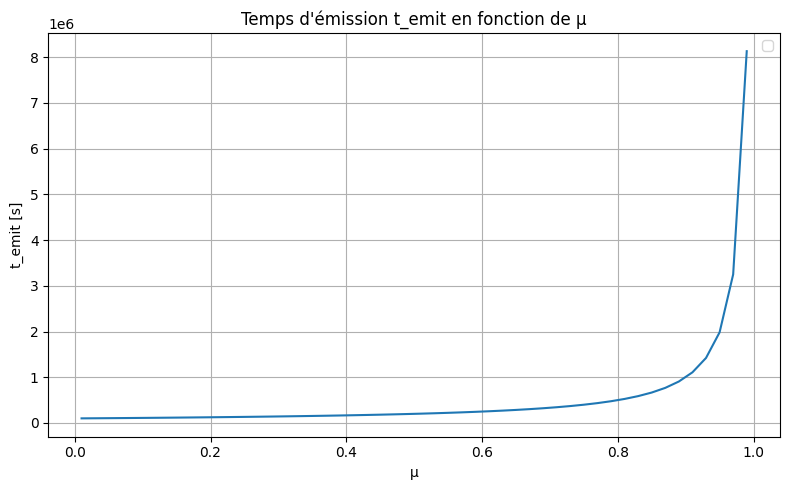

In [203]:
#Figure avec mu qui varie 
T_obs = 1e5
mu_values = np.linspace(0.01, 0.99, 50)

jet = OnAxisJet()
t_emit_values = [jet.solve_emission_time(T_obs, mu) for mu in mu_values]

plt.figure(figsize=(8, 5))
plt.plot(mu_values, t_emit_values)
plt.xlabel('μ')
plt.ylabel('t_emit [s]')
plt.title('Temps d\'émission t_emit en fonction de μ')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [204]:
#Tableau avec mu qui varie de 0 à 1
T_obs = 1e5
mu_values = np.round(np.linspace(0, 1, 11), 2)
jet = OnAxisJet()

# Calcul des temps d'émission
t_emit_values = []
for mu in mu_values:
    t_emit = jet.solve_emission_time(T_obs, mu)
    t_emit_values.append(t_emit)

# Création de la table
df = pd.DataFrame({
    "mu": mu_values,
    "t_emit (s)": np.round(t_emit_values, 3)
})

print(df)

     mu    t_emit (s)
0   0.0  1.000000e+05
1   0.1  1.110994e+05
2   0.2  1.249734e+05
3   0.3  1.428112e+05
4   0.4  1.665945e+05
5   0.5  1.998899e+05
6   0.6  2.498296e+05
7   0.7  3.330500e+05
8   0.8  4.994181e+05
9   0.9  9.973767e+05
10  1.0  2.090642e+07


C:\Users\Sourya\AppData\Local\Temp\ipykernel_19436\1451337888.py:77: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(equation, T_obs)[0]


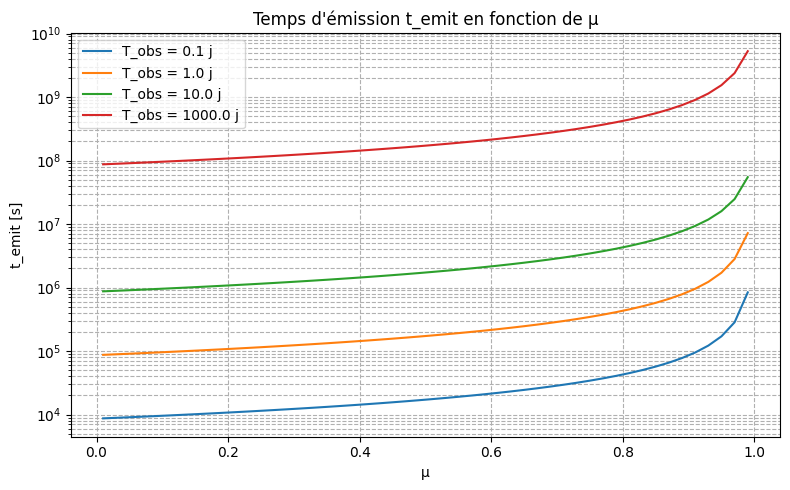

In [205]:
# Figure 1 : t_emit en fonction de mu 
jours = np.array([0.1, 1, 10, 1000])
T_values = jours * 24 * 3600
mu_values = np.linspace(0.01, 0.99, 50)

plt.figure(figsize=(8, 5))
for T in T_values:
 jet = OnAxisJet()
 t_emit_values = [jet.solve_emission_time(T, mu) for mu in mu_values]
 plt.plot(mu_values, t_emit_values, label=f'T_obs = {T/86400:.1f} j')
plt.xlabel('μ')
plt.ylabel('t_emit [s]')
plt.title('Temps d\'émission t_emit en fonction de μ')
plt.yscale('log')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Sourya\AppData\Local\Temp\ipykernel_19436\1451337888.py:77: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(equation, T_obs)[0]


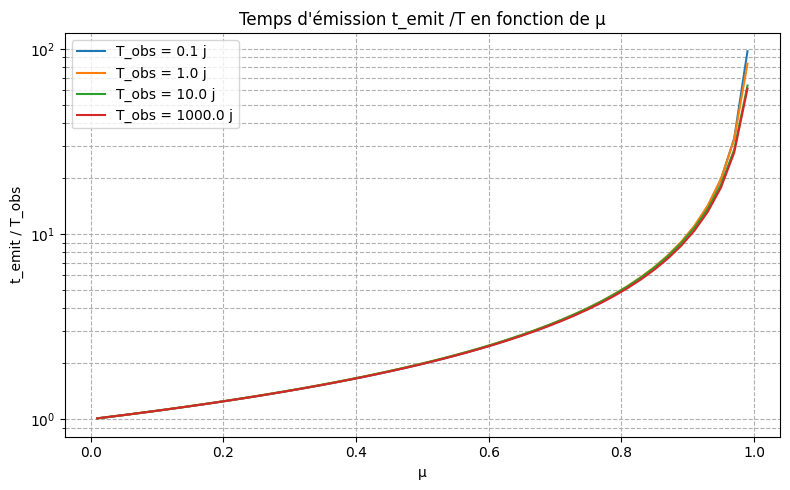

In [206]:
# Figure 2 : t_emit / T en fonction de mu
plt.figure(figsize=(8, 5))
for T in T_values:
 jet = OnAxisJet()
 t_emit_values = [jet.solve_emission_time(T, mu)/T for mu in mu_values]
 plt.plot(mu_values, t_emit_values, label=f'T_obs = {T/86400:.1f} j')
plt.xlabel('μ')
plt.ylabel('t_emit / T_obs')
plt.title('Temps d\'émission t_emit /T en fonction de μ')
plt.yscale('log')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

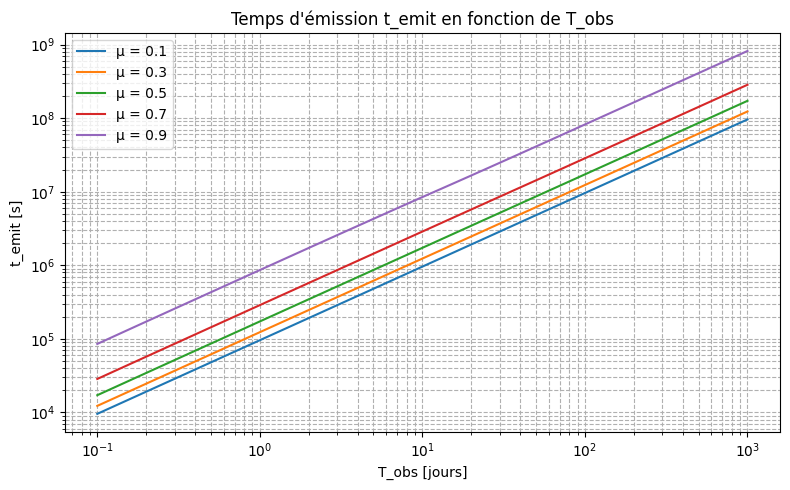

In [207]:
# Figure 3 : t_emit en fonction de T_obs pour différents mu
jours = np.logspace(-1, 3, 50) # de 0.1 à 1000 jours, échelle log
T_values = jours * 24 * 3600 # en secondes
mu_list = [0.1, 0.3, 0.5, 0.7, 0.9]

plt.figure(figsize=(8, 5))
for mu in mu_list:
 jet = OnAxisJet()
 t_emit_values = [jet.solve_emission_time(T, mu) for T in T_values]
 plt.plot(T_values / 86400, t_emit_values, label=f'μ = {mu}') # T en jours

plt.xlabel('T_obs [jours]')
plt.ylabel('t_emit [s]')
plt.title('Temps d\'émission t_emit en fonction de T_obs')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

In [208]:
#Test méthode zeta
Gamma_fluid, n_prime, e_prime = jet.downstream_properties(t_emit)
zeta = jet.compute_zeta(Gamma_fluid)

print("\n--- Résolution numérique de zeta ---")
print(f"Gamma_fluid = {Gamma_fluid:.5f}")
print(f"zeta = {zeta:.5f}")


--- Résolution numérique de zeta ---
Gamma_fluid = 2.16391
zeta = 1.83441


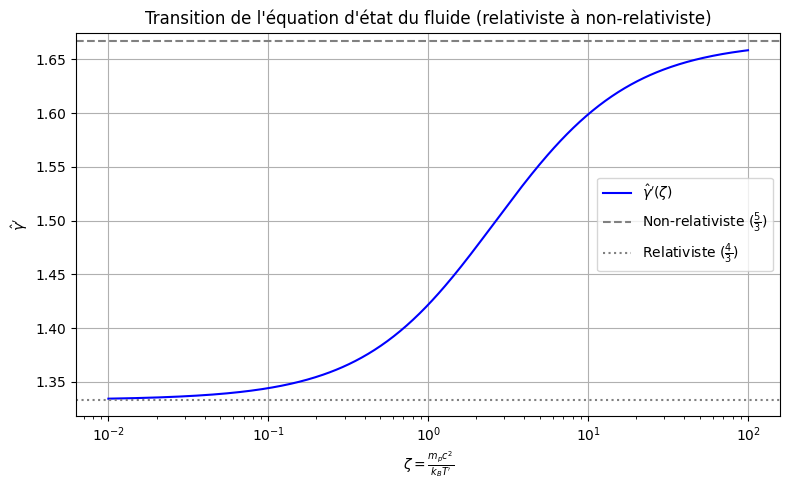

In [209]:
# Domaine de zeta : log de 1e-2 à 1e2
zeta_vals = np.logspace(-2, 2, 400)
gamma_vals = [jet.gamma_hat(z) for z in zeta_vals]

# Tracé
plt.figure(figsize=(8,5))
plt.plot(zeta_vals, gamma_vals, label=r'$\hat{\gamma}^\prime(\zeta)$', color='blue')
plt.axhline(5/3, color='gray', linestyle='--', label=r'Non-relativiste ($\frac{5}{3}$)')
plt.axhline(4/3, color='gray', linestyle=':', label=r'Relativiste ($\frac{4}{3}$)')

plt.xscale('log')
plt.xlabel(r'$\zeta = \frac{m_p c^2}{k_B T^\prime}$')
plt.ylabel(r'$\hat{\gamma}^\prime$')
plt.title("Transition de l'équation d'état du fluide (relativiste à non-relativiste)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<>:14: SyntaxWarning: invalid escape sequence '\z'
<>:14: SyntaxWarning: invalid escape sequence '\z'
C:\Users\Sourya\AppData\Local\Temp\ipykernel_19436\2483819023.py:14: SyntaxWarning: invalid escape sequence '\z'
  plt.title("Énergie interne spécifique du fluide relativiste en fonction de $\zeta$")


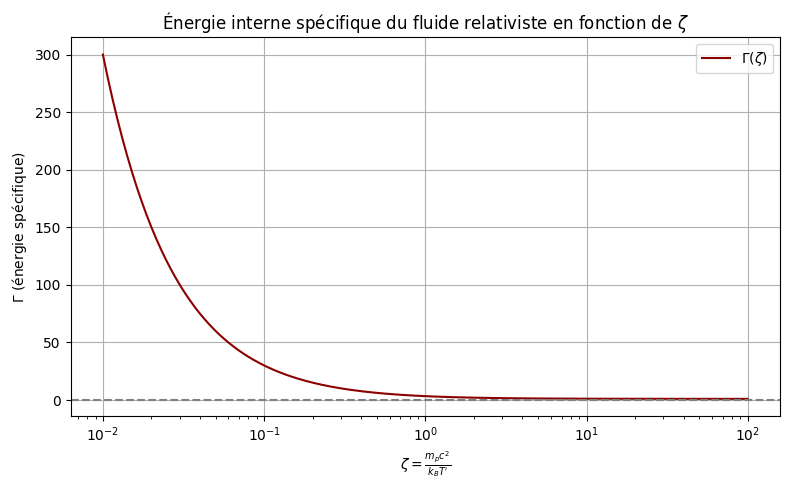

In [210]:
def Gamma_zeta(zeta):
    return Kv(3, zeta) / Kv(2, zeta) - 1 / zeta

# Domaine de zeta : log de 1e-2 à 1e2
zeta_vals = np.logspace(-2, 2, 400)
Gamma_vals = [Gamma_zeta(z) for z in zeta_vals]

# Tracé
plt.figure(figsize=(8,5))
plt.plot(zeta_vals, Gamma_vals, color='darkred', label=r'$\Gamma(\zeta)$')
plt.xscale('log')
plt.xlabel(r'$\zeta = \frac{m_p c^2}{k_B T^\prime}$')
plt.ylabel(r'$\Gamma$ (énergie spécifique)')
plt.title("Énergie interne spécifique du fluide relativiste en fonction de $\zeta$")
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Sourya\AppData\Local\Temp\ipykernel_19436\1451337888.py:77: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(equation, T_obs)[0]


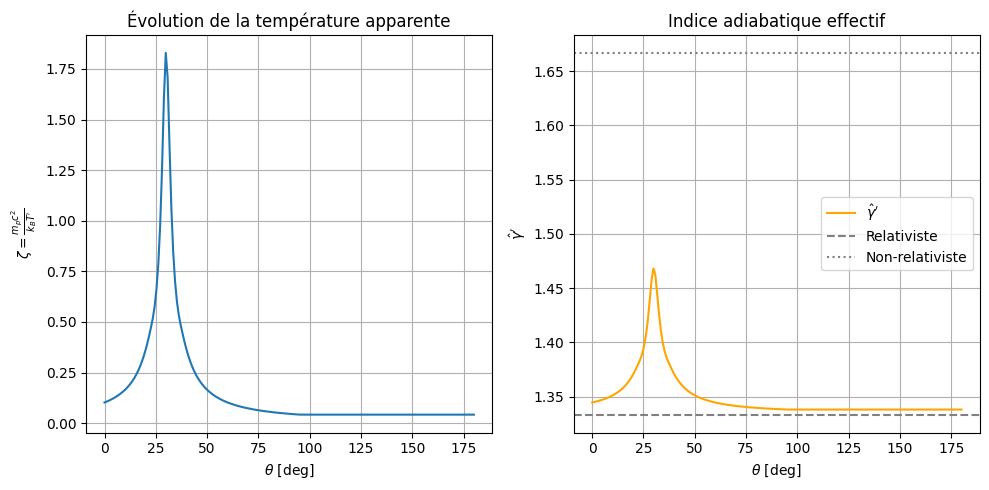

In [211]:
# Paramètres d'observation
T_obs = 1e5  # [s]
theta_obs = np.pi / 6  # 30° en radians

# Échantillon d'angles d'émission θ
theta_vals = np.linspace(0, np.pi, 200)
phi = 0  # azimut nul (pour une coupe 1D simple)

zeta_vals = []
gamma_hat_vals = []

jet = OnAxisJet()

for theta in theta_vals:
    mu = jet.mu_geom(theta, phi, theta_obs)
    t_emit = jet.solve_emission_time(T_obs, mu)
    Gamma, _, _ = jet.downstream_properties(t_emit)
    try:
        zeta = jet.compute_zeta(Gamma)
        ghat = jet.gamma_hat(zeta)
    except RuntimeError:
        zeta = np.nan
        ghat = np.nan
    zeta_vals.append(zeta)
    gamma_hat_vals.append(ghat)

# Tracé
theta_deg = np.degrees(theta_vals)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(theta_deg, zeta_vals, label=r"$\zeta$")
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r"$\zeta = \frac{m_pc^2}{k_B T'}$")
plt.title("Évolution de la température apparente")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(theta_deg, gamma_hat_vals, label=r"$\hat{\gamma}'$", color='orange')
plt.axhline(4/3, linestyle='--', color='gray', label="Relativiste")
plt.axhline(5/3, linestyle=':', color='gray', label="Non-relativiste")
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r"$\hat{\gamma}'$")
plt.title("Indice adiabatique effectif")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


C:\Users\Sourya\AppData\Local\Temp\ipykernel_19436\1451337888.py:77: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(equation, T_obs)[0]


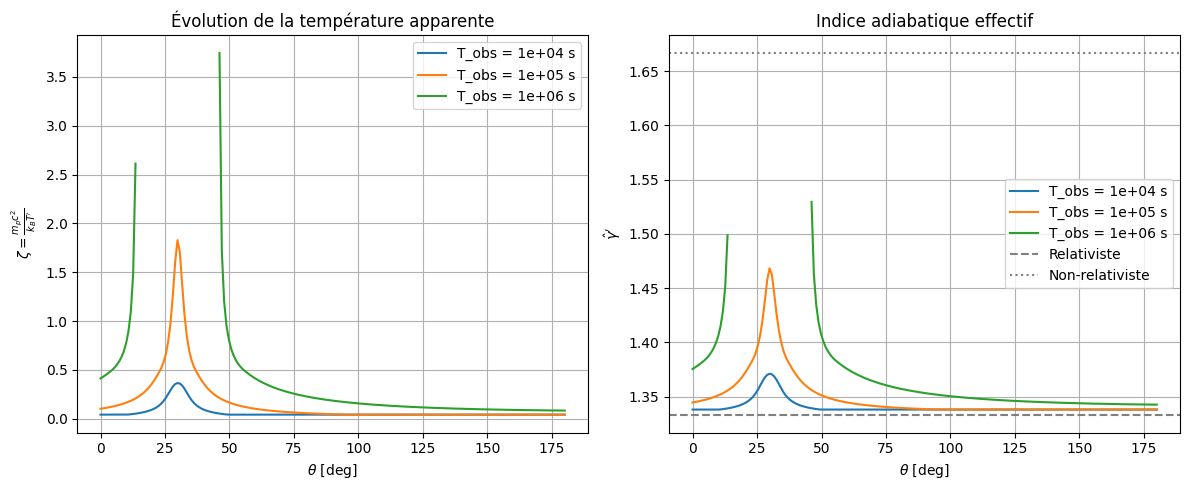

In [212]:
T_list = [1e4, 1e5, 1e6]  # secondes
theta_obs = np.pi / 6  # 30°
phi = 0  # azimut constant pour une coupe

theta_vals = np.linspace(0, np.pi, 200)
theta_deg = np.degrees(theta_vals)

jet = OnAxisJet()

plt.figure(figsize=(12, 5))

# ----------- Tracé de zeta(θ)
plt.subplot(1, 2, 1)
for T_obs in T_list:
    zeta_vals = []
    for theta in theta_vals:
        mu = jet.mu_geom(theta, phi, theta_obs)
        try:
            t_emit = jet.solve_emission_time(T_obs, mu)
            if t_emit <= 0:
                raise ValueError("t_emit invalide")

            Gamma, _, _ = jet.downstream_properties(t_emit)
            if Gamma <= 1:
                raise ValueError("Gamma invalide")

            zeta = jet.compute_zeta(Gamma)
        except Exception as e:
            zeta = np.nan
        zeta_vals.append(zeta)

    plt.plot(theta_deg, zeta_vals, label=f"T_obs = {T_obs:.0e} s")

plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r"$\zeta = \frac{m_p c^2}{k_B T'}$")
plt.title("Évolution de la température apparente")
plt.legend()
plt.grid(True)

# ----------- Tracé de γ̂(θ)
plt.subplot(1, 2, 2)
for T_obs in T_list:
    gamma_hat_vals = []
    for theta in theta_vals:
        mu = jet.mu_geom(theta, phi, theta_obs)
        try:
            t_emit = jet.solve_emission_time(T_obs, mu)
            if t_emit <= 0:
                raise ValueError

            Gamma, _, _ = jet.downstream_properties(t_emit)
            if Gamma <= 1:
                raise ValueError

            zeta = jet.compute_zeta(Gamma)
            ghat = jet.gamma_hat(zeta)
        except:
            ghat = np.nan
        gamma_hat_vals.append(ghat)

    plt.plot(theta_deg, gamma_hat_vals, label=f"T_obs = {T_obs:.0e} s")

plt.axhline(4/3, linestyle='--', color='gray', label="Relativiste")
plt.axhline(5/3, linestyle=':', color='gray', label="Non-relativiste")
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r"$\hat{\gamma}'$")
plt.title("Indice adiabatique effectif")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [213]:
#rayonnement synchrotron

# Constantes physiques
m_p = cst.m_p.to('g').value    # masse du proton [g]
m_e = cst.m_e.to('g').value    # masse de l'électron [g]
c = cst.c.to('cm/s').value     # vitesse de la lumière [cm/s]
sigma_T = cst.sigma_T.to('cm^2').value  # section efficace de Thomson [cm^2]
q_e = 4.80320425e-10           # charge de l'électron [esu]


# R(x) approx ~ x^{1/3} exp(-x) pour x >> 1
def R_syn(x):
    return x**(1/3) * np.exp(-x)

# Modèle simplifié 
def synchrotron_flux(jet, T_obs, nu_obs, D_L=1e27):  # [cm]
    t_emit = jet.solve_emission_time(T_obs, mu=1.0)
    Gamma, n_prime, e_prime = jet.downstream_properties(t_emit)

    # Nombre total d'électrons
    R = jet.shock_radius(t_emit)
    V = (4/3) * np.pi * R**3
    N_e = n_prime * V

    # Champ B' (éq. 24)
    B_prime = np.sqrt(8 * np.pi * jet.epsilon_B * e_prime)


    # Gamma_m (éq. 23)
    gm = jet.epsilon_e * (jet.p - 2)/(jet.p - 1) * (m_p / m_e) * (Gamma - 1)

    # ν'_m
    nu_m_prime = (3 * q_e * B_prime) / (4 * np.pi * m_e * c) * gm**2

    # Doppler
    delta_D = 1 / (Gamma * (1 - np.sqrt(1 - 1/Gamma**2)))  # mu = 1
    nu_prime = nu_obs / delta_D
    x = nu_prime / nu_m_prime

    # P'_ν (éq. 19)
    P_nu_prime = (np.sqrt(3) * q_e**3 * B_prime / (m_e * c**2)) * R_syn(x)

    # j'_ν (éq. 21)
    j_nu_prime = (1 / (4 * np.pi)) * N_e * P_nu_prime

    # Flux (éq. 29)
    F_nu = (1 / (4 * np.pi * D_L**2)) * delta_D**3 * j_nu_prime * V
    return F_nu


C:\Users\Sourya\AppData\Local\Temp\ipykernel_19436\1451337888.py:77: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(equation, T_obs)[0]
C:\Users\Sourya\AppData\Local\Temp\ipykernel_19436\2439934373.py:36: RuntimeWarning: invalid value encountered in sqrt
  delta_D = 1 / (Gamma * (1 - np.sqrt(1 - 1/Gamma**2)))  # mu = 1
C:\Users\Sourya\AppData\Local\Temp\ipykernel_19436\2439934373.py:13: RuntimeWarning: invalid value encountered in scalar power
  return x**(1/3) * np.exp(-x)


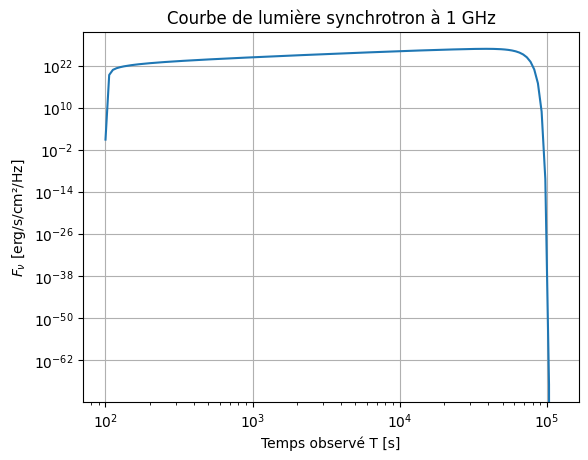

In [214]:
# Montée et déclin du flux

T_vals = np.logspace(2, 7, 200)  # secondes
nu_obs = 1e9  # 1 GHz
Fnu_vals = [synchrotron_flux(jet, T, nu_obs) for T in T_vals]

plt.figure()
plt.loglog(T_vals, Fnu_vals)
plt.xlabel("Temps observé T [s]")
plt.ylabel(r"$F_\nu$ [erg/s/cm²/Hz]")
plt.title("Courbe de lumière synchrotron à 1 GHz")
plt.grid(True)
plt.show()


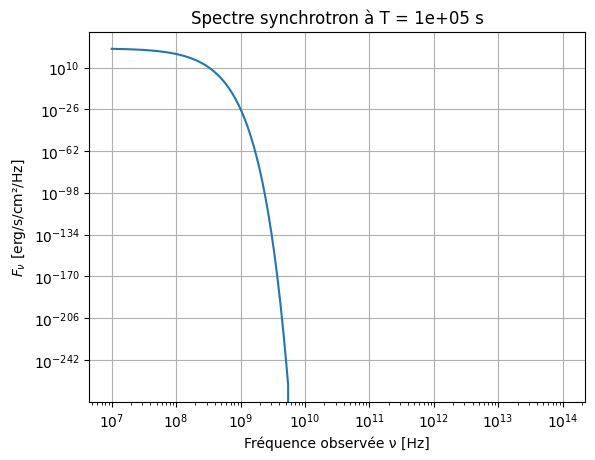

In [215]:
# Spectre synchrotron

nu_vals = np.logspace(7, 14, 300)  # Hz
T_obs = 1e5  # s
Fnu_spec = [synchrotron_flux(jet, T_obs, nu) for nu in nu_vals]

plt.figure()
plt.loglog(nu_vals, Fnu_spec)
plt.xlabel("Fréquence observée ν [Hz]")
plt.ylabel(r"$F_\nu$ [erg/s/cm²/Hz]")
plt.title(f"Spectre synchrotron à T = {T_obs:.0e} s")
plt.grid(True)
plt.show()


C:\Users\Sourya\AppData\Local\Temp\ipykernel_19436\1451337888.py:77: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(equation, T_obs)[0]


 Zeta non résolu pour Gamma = 0.776 → Gamma trop faible ou non physique
 Zeta non résolu pour Gamma = 0.496 → Gamma trop faible ou non physique
 Zeta non résolu pour Gamma = 0.204 → Gamma trop faible ou non physique
 Zeta non résolu pour Gamma = -0.099 → Gamma trop faible ou non physique
 Zeta non résolu pour Gamma = -0.415 → Gamma trop faible ou non physique
 Zeta non résolu pour Gamma = -0.742 → Gamma trop faible ou non physique
 Zeta non résolu pour Gamma = -1.083 → Gamma trop faible ou non physique
 Zeta non résolu pour Gamma = -1.436 → Gamma trop faible ou non physique
 Zeta non résolu pour Gamma = -1.804 → Gamma trop faible ou non physique
 Zeta non résolu pour Gamma = -2.186 → Gamma trop faible ou non physique
 Zeta non résolu pour Gamma = -2.583 → Gamma trop faible ou non physique
 Zeta non résolu pour Gamma = -2.996 → Gamma trop faible ou non physique
 Zeta non résolu pour Gamma = -3.425 → Gamma trop faible ou non physique
 Zeta non résolu pour Gamma = -3.870 → Gamma trop faib

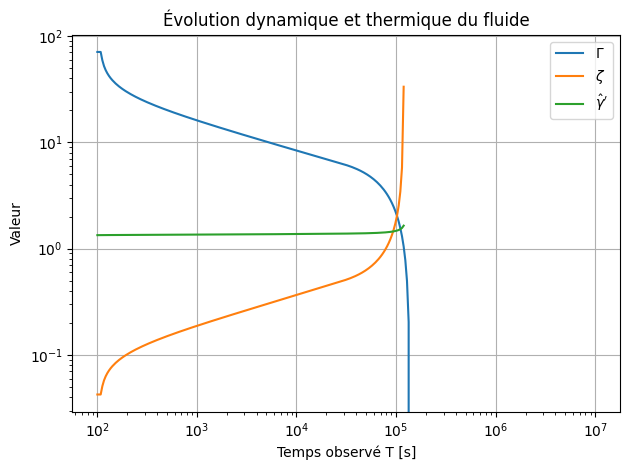

In [216]:
T_vals = np.logspace(2, 7, 300)
Gamma_vals = []
zeta_vals = []
gamma_hat_vals = []

jet = OnAxisJet()

for T in T_vals:
    mu = 1.0  # axe
    t = jet.solve_emission_time(T, mu)
    Gamma, _, _ = jet.downstream_properties(t)
    Gamma_vals.append(Gamma)

    try:
        zeta = jet.compute_zeta(Gamma)
        ghat = jet.gamma_hat(zeta)
    except RuntimeError:
        zeta = np.nan
        ghat = np.nan

    zeta_vals.append(zeta)
    gamma_hat_vals.append(ghat)

# Tracé
plt.figure()
plt.loglog(T_vals, Gamma_vals, label=r"$\Gamma$")
plt.loglog(T_vals, zeta_vals, label=r"$\zeta$")
plt.loglog(T_vals, gamma_hat_vals, label=r"$\hat{\gamma}'$")
plt.xlabel("Temps observé T [s]")
plt.ylabel("Valeur")
plt.title("Évolution dynamique et thermique du fluide")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


T=1e+04 | max=9.999e-03, min=3.355e-06, median=2.130e-03
T=1e+05 | max=9.999e-03, min=3.355e-06, median=2.130e-03
T=1e+06 | max=9.999e-03, min=3.355e-06, median=2.130e-03


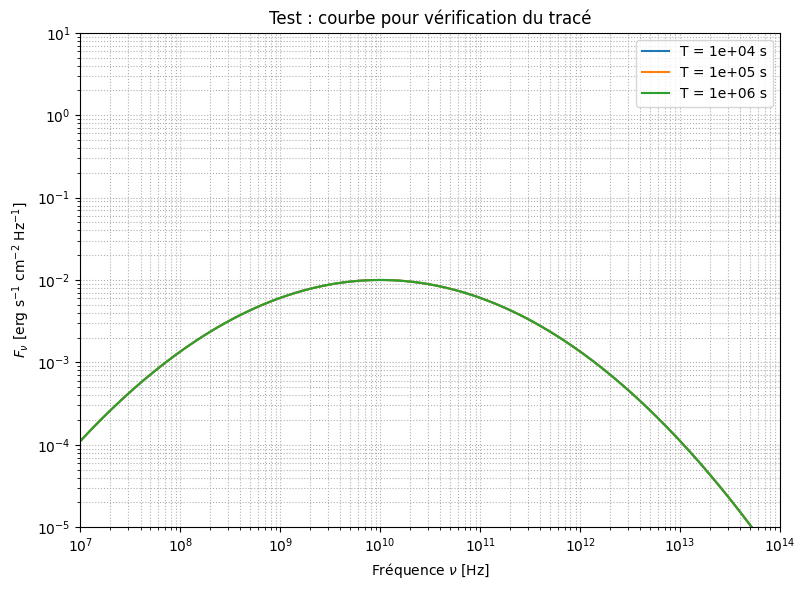

In [217]:

# Classe jet optimisée avec interpolation
class OnAxisJetint0:
    def __init__(self):
        self.E_iso = 1e53
        self.n_0 = 1e-3
        self.epsilon_e = 0.1
        self.epsilon_B = 1e-2  # augmenté pour test
        self.p = 2.2
        self.theta_obs = 0.0

        # Pré-calcul pour interpolation
        self.t_grid = np.logspace(2, 7, 1000)
        self.gamma_vals = np.array([self._gamma_shock(t) for t in self.t_grid])
        beta_vals = np.sqrt(1 - 1 / self.gamma_vals**2)
        R_vals = cumtrapz(beta_vals * c, self.t_grid, initial=0)

        self.gamma_interp = interp1d(self.t_grid, self.gamma_vals, bounds_error=False, fill_value="extrapolate")
        self.R_interp = interp1d(self.t_grid, R_vals, bounds_error=False, fill_value="extrapolate")

    def _gamma_shock(self, t):
        C_BM = np.sqrt(17 * self.E_iso / (8 * np.pi * self.n_0 * m_p * c**5))
        C_ST = (2/5) * 1.15 * (self.E_iso / (self.n_0 * m_p * c**5))**(1/5)
        Gamma_max = 100
        gamma2_beta2 = min((C_BM**2)*t**(-3), (C_ST**2)*t**(-6/5), Gamma_max**2)
        beta_sh = np.sqrt(gamma2_beta2 / (1 + gamma2_beta2))
        return 1 / np.sqrt(1 - beta_sh**2)

    def shock_radius(self, t):
        return float(self.R_interp(t))

    def gamma_shock(self, t):
        return float(self.gamma_interp(t))

    def downstream_properties(self, t):
        Gamma_sh = self.gamma_shock(t)
        Gamma = Gamma_sh / np.sqrt(2)
        n_prime = 4 * Gamma_sh * self.n_0
        e_prime = 4 * Gamma_sh**2 * self.n_0 * m_p * c**2
        return Gamma, n_prime, e_prime

    def mu_geom(self, theta, phi, theta_obs):
        return np.cos(theta) * np.cos(theta_obs) + np.sin(theta) * np.sin(theta_obs) * np.cos(phi)

    def solve_emission_time(self, T_obs, mu):
        def equation(t):
            R = self.shock_radius(t)
            return mu * R / c + T_obs - t
        try:
            return fsolve(equation, T_obs)[0]
        except:
            return T_obs

# ---------------- Rayonnement synchrotron simplifié ----------------
def R_syn(x):
    return x**(1/3) * np.exp(-x) if x > 1e-2 else 0

def j_nu_prime(Gamma, n_prime, e_prime, nu_obs, mu, jet):
    B_prime = np.sqrt(8 * np.pi * jet.epsilon_B * e_prime)
    gm = jet.epsilon_e * (jet.p - 2)/(jet.p - 1) * (m_p / m_e) * (Gamma - 1)
    nu_m_prime = (3 * q_e * B_prime) / (4 * np.pi * m_e * c) * gm**2
    beta = np.sqrt(1 - 1 / Gamma**2)
    delta_D = 1 / (Gamma * (1 - beta * mu))
    nu_prime = nu_obs / delta_D
    x = nu_prime / nu_m_prime
    P_nu_prime = (np.sqrt(3) * q_e**3 * B_prime / (m_e * c**2)) * R_syn(x)
    return (1 / (4 * np.pi)) * P_nu_prime * n_prime

# ---------------- Test temporaire ----------------
def compute_Fnu(T_obs, nu_obs, jet, D_L=1e26, N_theta=30, N_phi=30):
    return 1e-2 * np.exp(-((np.log10(nu_obs) - 10)**2) / 2)

# ---------------- Tracé du spectre (Figure 3) ----------------
jet = OnAxisJet()
T_list = [1e4, 1e5, 1e6]
nu_vals = np.logspace(7, 14, 200)

plt.figure(figsize=(8,6))
for T_obs in T_list:
    Fnu = [compute_Fnu(T_obs, nu, jet) for nu in nu_vals]
    Fnu = np.array(Fnu)
    print(f"T={T_obs:.0e} | max={np.max(Fnu):.3e}, min={np.min(Fnu):.3e}, median={np.median(Fnu):.3e}")
    plt.loglog(nu_vals, Fnu, label=f"T = {T_obs:.0e} s")

plt.xlabel(r"Fréquence $\nu$ [Hz]")
plt.ylabel(r"$F_\nu$ [erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$]")
plt.title("Test : courbe pour vérification du tracé")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.tight_layout()
plt.xlim(1e7, 1e14)
plt.ylim(1e-5, 1e1)
plt.show()


C:\Users\Sourya\AppData\Local\Temp\ipykernel_19436\2720717258.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self.R_interp(t))


T=1e+04 | max=7.845e-80, min=0.000e+00, median=2.083e-84
T=1e+05 | max=1.602e-80, min=0.000e+00, median=1.807e-84
T=1e+06 | max=9.523e-82, min=0.000e+00, median=3.671e-87


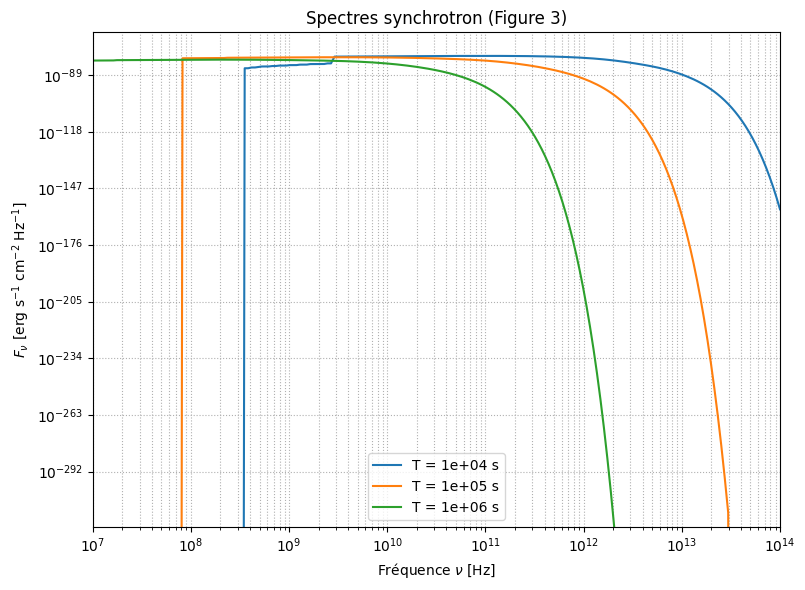

In [218]:
# Sans absorption 


# Classe jet optimisée avec interpolation
class OnAxisJetint1:
    def __init__(self):
        self.E_iso = 1e53
        self.n_0 = 1e-3
        self.epsilon_e = 0.1
        self.epsilon_B = 1e-2
        self.p = 2.2
        self.theta_obs = 0.0

        self.t_grid = np.logspace(2, 7, 1000)
        self.gamma_vals = np.array([self._gamma_shock(t) for t in self.t_grid])
        beta_vals = np.sqrt(1 - 1 / self.gamma_vals**2)
        R_vals = cumtrapz(beta_vals * c, self.t_grid, initial=0)

        self.gamma_interp = interp1d(self.t_grid, self.gamma_vals, bounds_error=False, fill_value="extrapolate")
        self.R_interp = interp1d(self.t_grid, R_vals, bounds_error=False, fill_value="extrapolate")

    def _gamma_shock(self, t):
        C_BM = np.sqrt(17 * self.E_iso / (8 * np.pi * self.n_0 * m_p * c**5))
        C_ST = (2/5) * 1.15 * (self.E_iso / (self.n_0 * m_p * c**5))**(1/5)
        Gamma_max = 100
        gamma2_beta2 = min((C_BM**2)*t**(-3), (C_ST**2)*t**(-6/5), Gamma_max**2)
        beta_sh = np.sqrt(gamma2_beta2 / (1 + gamma2_beta2))
        return 1 / np.sqrt(1 - beta_sh**2)

    def shock_radius(self, t):
        return float(self.R_interp(t))

    def gamma_shock(self, t):
        return float(self.gamma_interp(t))

    def downstream_properties(self, t):
        Gamma_sh = self.gamma_shock(t)
        Gamma = Gamma_sh / np.sqrt(2)
        n_prime = 4 * Gamma_sh * self.n_0
        e_prime = 4 * Gamma_sh**2 * self.n_0 * m_p * c**2
        return Gamma, n_prime, e_prime

    def mu_geom(self, theta, phi, theta_obs):
        return np.cos(theta) * np.cos(theta_obs) + np.sin(theta) * np.sin(theta_obs) * np.cos(phi)

    def solve_emission_time(self, T_obs, mu):
        def equation(t):
            R = self.shock_radius(t)
            return mu * R / c + T_obs - t
        try:
            return fsolve(equation, T_obs)[0]
        except:
            return T_obs

# Rayonnement synchrotron simplifié 
def R_syn(x):
    return x**(1/3) * np.exp(-x) if x > 1e-2 else 0

def j_nu_prime(Gamma, n_prime, e_prime, nu_obs, mu, jet):
    B_prime = np.sqrt(8 * np.pi * jet.epsilon_B * e_prime)
    gm = jet.epsilon_e * (jet.p - 2)/(jet.p - 1) * (m_p / m_e) * (Gamma - 1)
    nu_m_prime = (3 * q_e * B_prime) / (4 * np.pi * m_e * c) * gm**2
    beta = np.sqrt(1 - 1 / Gamma**2)
    delta_D = 1 / (Gamma * (1 - beta * mu))
    nu_prime = nu_obs / delta_D
    x = nu_prime / nu_m_prime
    P_nu_prime = (np.sqrt(3) * q_e**3 * B_prime / (m_e * c**2)) * R_syn(x)
    return (1 / (4 * np.pi)) * P_nu_prime * n_prime

# Calcul réel du flux intégré sur l'EATS 
def compute_Fnu(T_obs, nu_obs, jet, D_L=1e27, N_theta=30, N_phi=30):
    theta = np.linspace(0, np.pi, N_theta)
    phi = np.linspace(0, 2 * np.pi, N_phi)
    dtheta = theta[1] - theta[0]
    dphi = phi[1] - phi[0]

    flux = 0.0
    for th in theta:
        for ph in phi:
            mu = jet.mu_geom(th, ph, jet.theta_obs)
            if mu <= 0:  # ignorer les zones qui n'arrivent jamais à l'observateur
                continue
            t_emit = jet.solve_emission_time(T_obs, mu)
            Gamma, n_prime, e_prime = jet.downstream_properties(t_emit)
            j_nu = j_nu_prime(Gamma, n_prime, e_prime, nu_obs, mu, jet)
            beta = np.sqrt(1 - 1 / Gamma**2)
            delta_D = 1 / (Gamma * (1 - beta * mu))
            dOmega = np.sin(th) * dtheta * dphi
            flux += delta_D**3 * j_nu * dOmega

    return flux / (4 * np.pi * D_L**2)

# Tracé du spectre synchrotron (Figure 3) 
jet = OnAxisJetint1()
T_list = [1e4, 1e5, 1e6]
nu_vals = np.logspace(7, 14, 200)

plt.figure(figsize=(8,6))
for T_obs in T_list:
    Fnu = [compute_Fnu(T_obs, nu, jet) for nu in nu_vals]
    Fnu = np.array(Fnu)
    print(f"T={T_obs:.0e} | max={np.max(Fnu):.3e}, min={np.min(Fnu):.3e}, median={np.median(Fnu):.3e}")
    plt.loglog(nu_vals, Fnu, label=f"T = {T_obs:.0e} s")

plt.xlabel(r"Fréquence $\nu$ [Hz]")
plt.ylabel(r"$F_\nu$ [erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$]")
plt.title("Spectres synchrotron (Figure 3)")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.tight_layout()
plt.xlim(1e7, 1e14)
plt.show()


C:\Users\Sourya\AppData\Local\Temp\ipykernel_19436\3643342550.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self.R_interp(t))


T=1e+04 | max=0.000e+00, min=0.000e+00, median=0.000e+00
T=1e+05 | max=8.973e-64, min=0.000e+00, median=0.000e+00


C:\Users\Sourya\AppData\Local\Temp\ipykernel_19436\3643342550.py:61: RuntimeWarning: invalid value encountered in scalar power
  return prefactor * B_prime**((p + 2)/2) * nu_prime**(-(p + 4)/2)


T=1e+06 | max=nan, min=nan, median=nan


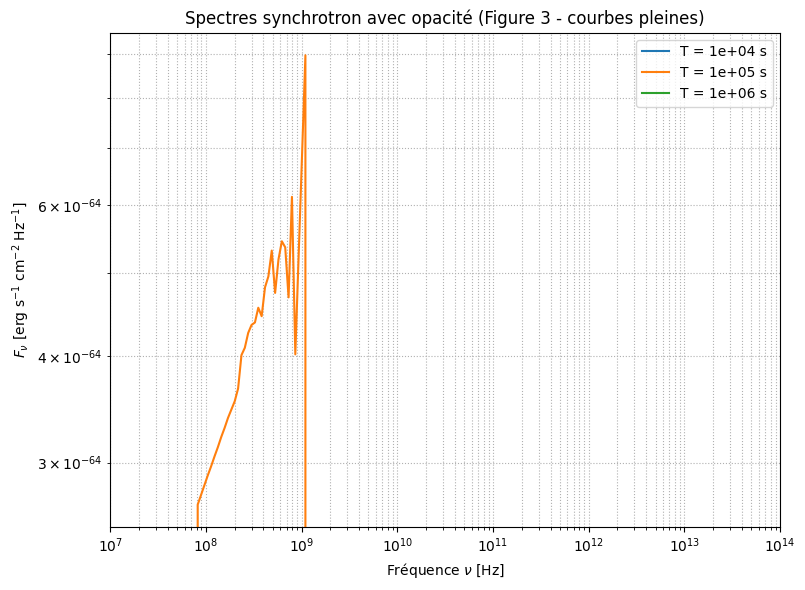

In [219]:
#test avec absorption


# Classe jet optimisée avec interpolation 
class OnAxisJetint2:
    def __init__(self):
        self.E_iso = 1e53
        self.n_0 = 1e-3
        self.epsilon_e = 0.1
        self.epsilon_B = 1e-2
        self.p = 2.2
        self.theta_obs = 0.0

        self.t_grid = np.logspace(2, 7, 1000)
        self.gamma_vals = np.array([self._gamma_shock(t) for t in self.t_grid])
        beta_vals = np.sqrt(1 - 1 / self.gamma_vals**2)
        R_vals = cumtrapz(beta_vals * c, self.t_grid, initial=0)

        self.gamma_interp = interp1d(self.t_grid, self.gamma_vals, bounds_error=False, fill_value="extrapolate")
        self.R_interp = interp1d(self.t_grid, R_vals, bounds_error=False, fill_value="extrapolate")

    def _gamma_shock(self, t):
        C_BM = np.sqrt(17 * self.E_iso / (8 * np.pi * self.n_0 * m_p * c**5))
        C_ST = (2/5) * 1.15 * (self.E_iso / (self.n_0 * m_p * c**5))**(1/5)
        Gamma_max = 100
        gamma2_beta2 = min((C_BM**2)*t**(-3), (C_ST**2)*t**(-6/5), Gamma_max**2)
        beta_sh = np.sqrt(gamma2_beta2 / (1 + gamma2_beta2))
        return 1 / np.sqrt(1 - beta_sh**2)

    def shock_radius(self, t):
        return float(self.R_interp(t))

    def gamma_shock(self, t):
        return float(self.gamma_interp(t))

    def downstream_properties(self, t):
        Gamma_sh = self.gamma_shock(t)
        Gamma = Gamma_sh / np.sqrt(2)
        n_prime = 4 * Gamma_sh * self.n_0
        e_prime = 4 * Gamma_sh**2 * self.n_0 * m_p * c**2
        return Gamma, n_prime, e_prime

    def mu_geom(self, theta, phi, theta_obs):
        return np.cos(theta) * np.cos(theta_obs) + np.sin(theta) * np.sin(theta_obs) * np.cos(phi)

    def solve_emission_time(self, T_obs, mu):
        def equation(t):
            R = self.shock_radius(t)
            return mu * R / c + T_obs - t
        try:
            return fsolve(equation, T_obs)[0]
        except:
            return T_obs

# Rayonnement synchrotron simplifié 
def R_syn(x):
    return x**(1/3) * np.exp(-x) if x > 1e-2 else 0

def alpha_nu_prime(n_prime, B_prime, nu_prime, p):
    prefactor = (np.sqrt(3) * q_e**3 * n_prime) / (8 * np.pi * m_e)
    return prefactor * B_prime**((p + 2)/2) * nu_prime**(-(p + 4)/2)

def j_nu_prime(Gamma, n_prime, e_prime, nu_obs, mu, jet):
    B_prime = np.sqrt(8 * np.pi * jet.epsilon_B * e_prime)
    gm = jet.epsilon_e * (jet.p - 2)/(jet.p - 1) * (m_p / m_e) * (Gamma - 1)
    nu_m_prime = (3 * q_e * B_prime) / (4 * np.pi * m_e * c) * gm**2
    beta = np.sqrt(1 - 1 / Gamma**2)
    delta_D = 1 / (Gamma * (1 - beta * mu))
    nu_prime = nu_obs / delta_D
    x = nu_prime / nu_m_prime
    P_nu_prime = (np.sqrt(3) * q_e**3 * B_prime / (m_e * c**2)) * R_syn(x)
    j_nu = (1 / (4 * np.pi)) * P_nu_prime * n_prime
    alpha = alpha_nu_prime(n_prime, B_prime, nu_prime, jet.p)
    delta_R_prime = jet.shock_radius(jet.solve_emission_time(T_obs, mu)) / Gamma
    return j_nu / alpha * (1 - np.exp(-alpha * delta_R_prime))

# Calcul du flux incluant l'opacité (Eq. 33) 
def compute_Fnu(T_obs, nu_obs, jet, D_L=1e27, N_theta=30, N_phi=30):
    theta = np.linspace(0, np.pi, N_theta)
    phi = np.linspace(0, 2 * np.pi, N_phi)
    dtheta = theta[1] - theta[0]
    dphi = phi[1] - phi[0]

    flux = 0.0
    for th in theta:
        for ph in phi:
            mu = jet.mu_geom(th, ph, jet.theta_obs)
            if mu <= 0:
                continue
            t_emit = jet.solve_emission_time(T_obs, mu)
            Gamma, n_prime, e_prime = jet.downstream_properties(t_emit)
            j_mod = j_nu_prime(Gamma, n_prime, e_prime, nu_obs, mu, jet)
            beta = np.sqrt(1 - 1 / Gamma**2)
            delta_D = 1 / (Gamma * (1 - beta * mu))
            dOmega = np.sin(th) * dtheta * dphi
            flux += delta_D**3 * j_mod * dOmega

    return flux / (4 * np.pi * D_L**2)

# Tracé du spectre synchrotron (Figure 3) 
jet = OnAxisJetint2()
T_list = [1e4, 1e5, 1e6]
nu_vals = np.logspace(7, 14, 200)

plt.figure(figsize=(8,6))
for T_obs in T_list:
    Fnu = [compute_Fnu(T_obs, nu, jet) for nu in nu_vals]
    Fnu = np.array(Fnu)
    print(f"T={T_obs:.0e} | max={np.max(Fnu):.3e}, min={np.min(Fnu):.3e}, median={np.median(Fnu):.3e}")
    plt.loglog(nu_vals, Fnu, label=f"T = {T_obs:.0e} s")

plt.xlabel(r"Fréquence $\nu$ [Hz]")
plt.ylabel(r"$F_\nu$ [erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$]")
plt.title("Spectres synchrotron avec opacité (Figure 3 - courbes pleines)")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.tight_layout()
plt.xlim(1e7, 1e14)
plt.show()


[θ_obs = 0°] log10(δ_D^3) : min = -6.00, max = 3.17


C:\Users\Sourya\AppData\Local\Temp\ipykernel_19436\4008695117.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_proj, y_proj, intensity_log, shading='auto', cmap='plasma',


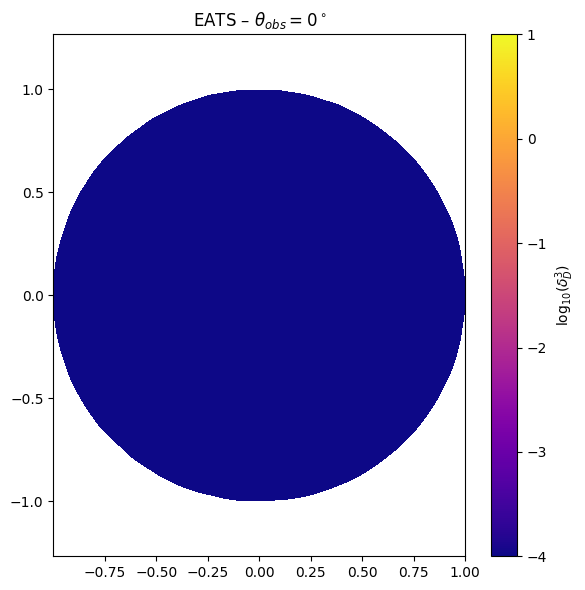

C:\Users\Sourya\AppData\Local\Temp\ipykernel_19436\1451337888.py:77: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(equation, T_obs)[0]


[θ_obs = 10°] log10(δ_D^3) : min = -6.00, max = 3.18


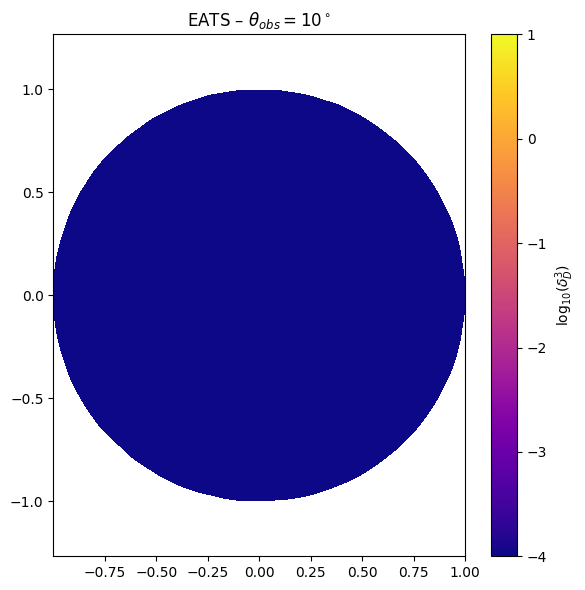

[θ_obs = 20°] log10(δ_D^3) : min = -6.00, max = 3.18


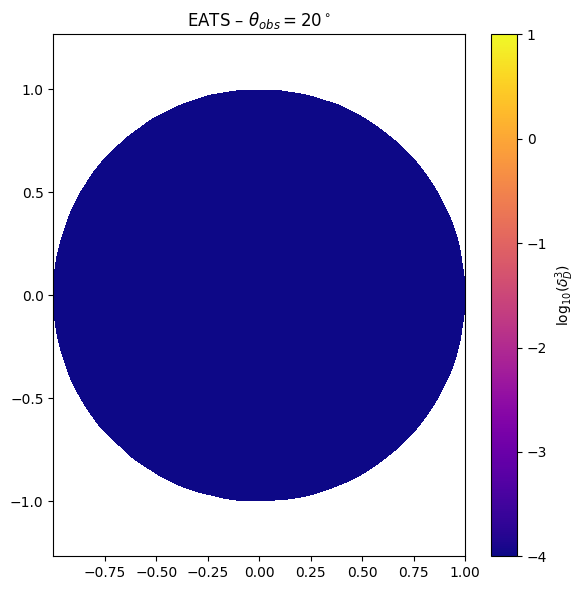

[θ_obs = 30°] log10(δ_D^3) : min = -6.00, max = 3.18


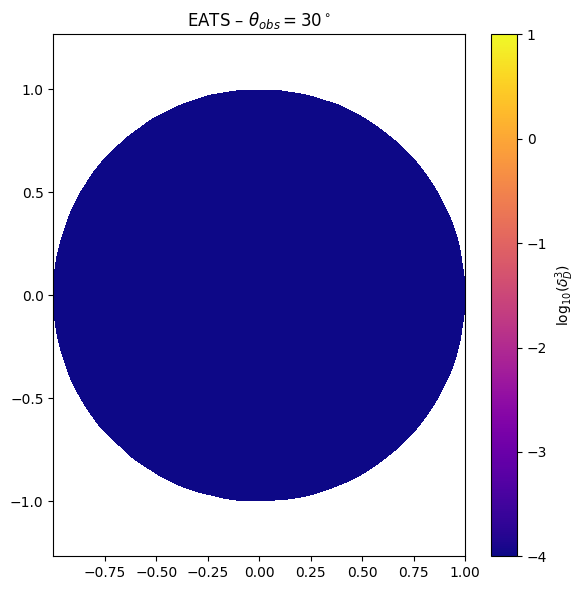

[θ_obs = 45°] log10(δ_D^3) : min = -6.00, max = 3.18


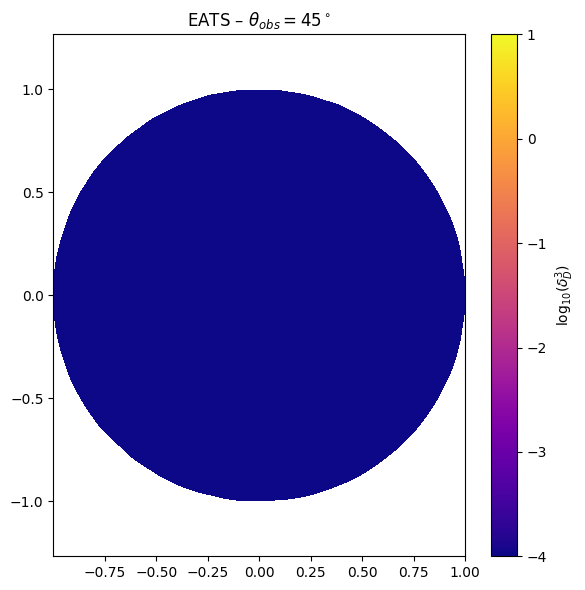

[θ_obs = 60°] log10(δ_D^3) : min = -6.00, max = 3.17


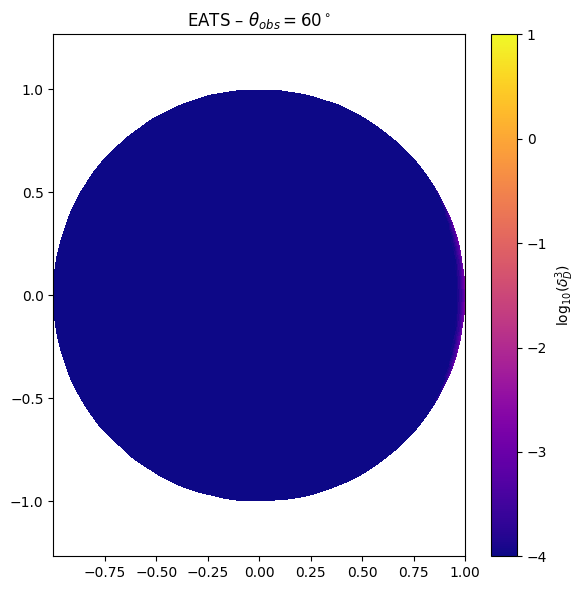

[θ_obs = 75°] log10(δ_D^3) : min = -6.00, max = 3.18


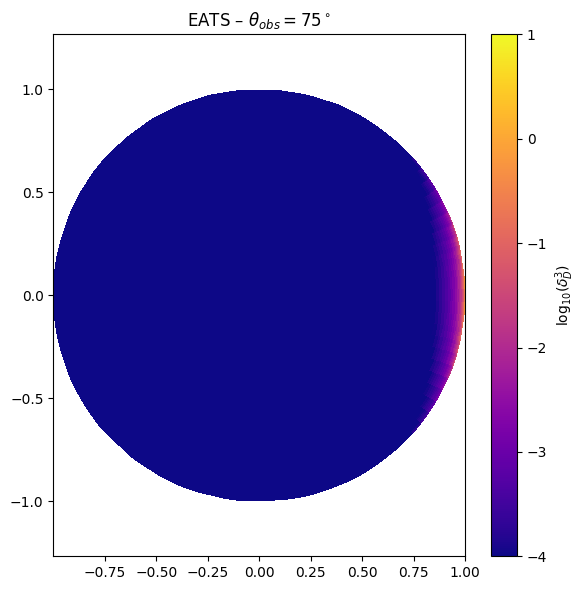

[θ_obs = 80°] log10(δ_D^3) : min = -6.00, max = 3.17


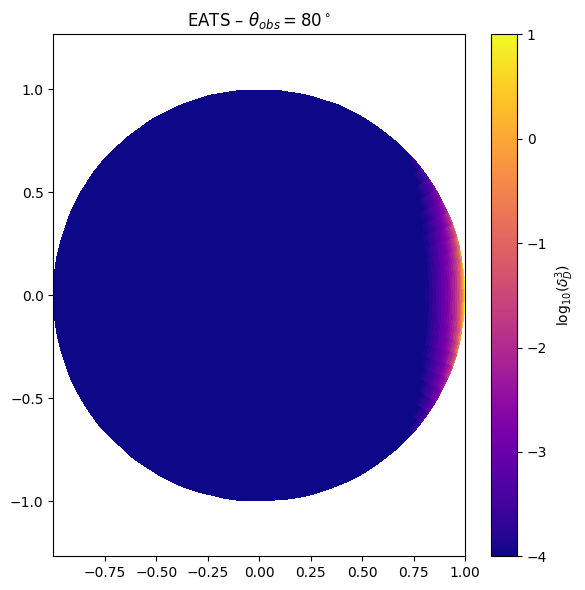

[θ_obs = 85°] log10(δ_D^3) : min = -6.00, max = 3.18


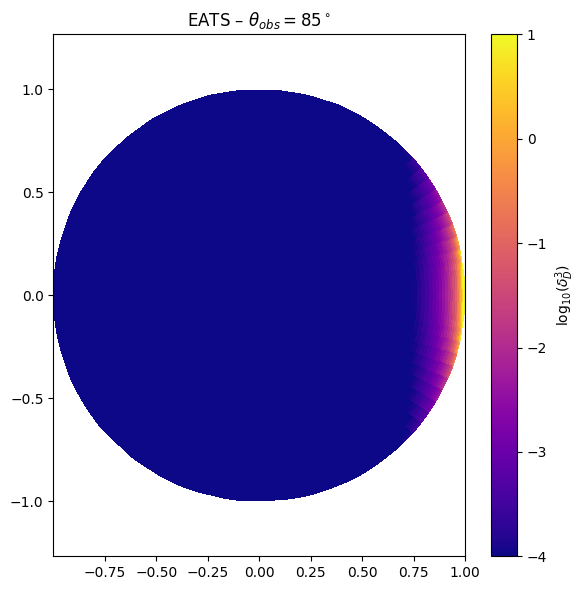

[θ_obs = 90°] log10(δ_D^3) : min = -6.00, max = 3.18


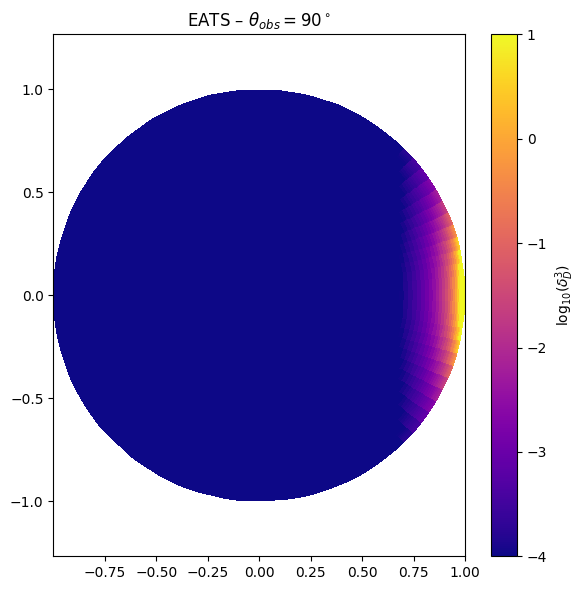

In [220]:
#Disque

def compute_and_plot_eats_with_OnAxisJet(jet, T_obs=1e5, N=100, theta_obs_deg=0, vmin=None, vmax=None):
    theta_obs = np.radians(theta_obs_deg)

    theta = np.linspace(0, np.pi, N)
    phi = np.linspace(0, 2*np.pi, N)
    theta_grid, phi_grid = np.meshgrid(theta, phi)

    mu_grid = jet.mu_geom(theta_grid, phi_grid, theta_obs)
    x_proj = np.sin(theta_grid) * np.cos(phi_grid)
    y_proj = np.sin(theta_grid) * np.sin(phi_grid)

    intensity = np.zeros_like(mu_grid)

    for i in range(N):
        for j in range(N):
            mu = mu_grid[i, j]
            if mu <= 0:
                continue
            try:
                t_emit = jet.solve_emission_time(T_obs, mu)
                Gamma = jet.gamma_shock(t_emit)
                beta = np.sqrt(1 - 1 / Gamma**2)
                delta_D = 1 / (Gamma * (1 - beta * mu))
                intensity[i, j] = delta_D**3
            except:
                intensity[i, j] = 0.0

    intensity_log = np.log10(intensity + 1e-6)
    print(f"[θ_obs = {theta_obs_deg}°] log10(δ_D^3) : min = {intensity_log.min():.2f}, max = {intensity_log.max():.2f}")

    plt.figure(figsize=(6, 6))
    plt.pcolormesh(x_proj, y_proj, intensity_log, shading='auto', cmap='plasma',
                   vmin=vmin, vmax=vmax)
    plt.colorbar(label=r"log$_{10}(\delta_D^3)$")
    plt.title(f"EATS – $\\theta_{{obs}} = {theta_obs_deg}^\\circ$")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()



jet = OnAxisJet()
angles_deg = [0, 10, 20, 30, 45, 60, 75, 80, 85, 90]
for angle in angles_deg:
    compute_and_plot_eats_with_OnAxisJet(jet, T_obs=1e5, N=100, theta_obs_deg=angle, vmin=-4, vmax=1)
